# Portiloop Demo

This notebook uses some fake data made to look like EEG to show how you would go about training a model and deploying it on the Portiloop.

#### Imports

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
from torchaudio.functional import convolve
from pytorch_lightning.callbacks import ModelCheckpoint

#### Dataset creation

Dataset used for training:

In [2]:
class CustomDataset(Dataset):
    def __init__(self, frequency, length, positive_ratio=0.5, num_samples=1000):
        self.frequency = frequency
        self.sequence_length = frequency * length
        self.positive_ratio = positive_ratio
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        is_positive = torch.rand(1) < self.positive_ratio

        if is_positive:
            sample = self.generate_positive_sample()
        else:
            sample = self.generate_negative_sample()

        sample = rearrange(sample, 'l -> 1 l')

        return sample, float(is_positive)

    def generate_positive_sample(self):
        # Get a sine wave of 1Hz
        x = torch.arange(0, self.sequence_length)
        # Add an attenuator which grows exponentially and then decays exponentially
        inc = (torch.arange(0, self.sequence_length//2) / self.frequency)
        dec = torch.flip(inc, dims=[0])  # reverse the attenuator
        attenuator = torch.cat([inc, dec])
        y = attenuator * torch.sin(2 * torch.pi * x / self.frequency)
        noise = torch.randn(self.sequence_length)
        noise = convolve(noise, torch.ones(30) / 30, mode='same')
        y += noise

        return y

    def generate_negative_sample(self):
        y = torch.randn(self.sequence_length)
        y = convolve(y, torch.ones(30) / 30, mode='same')
        return y

In [3]:
# Define the dataset
dataset = CustomDataset(frequency=250, length=5, positive_ratio=0.5, num_samples=1000)

dataset[0]
# Create a data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

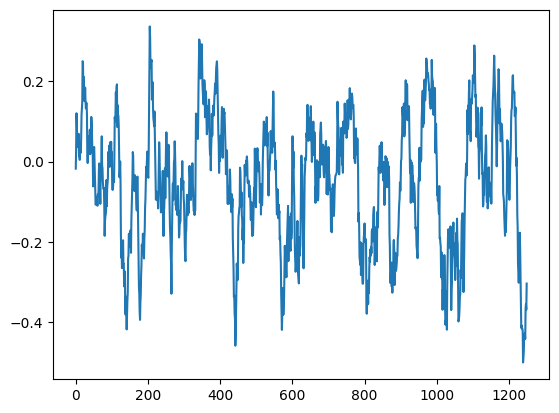

In [4]:
plt.plot(dataset.generate_negative_sample())

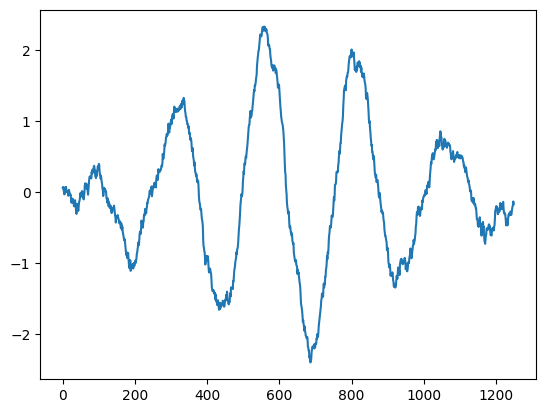

In [5]:
plt.plot(dataset.generate_positive_sample())

In [7]:
num_channels = 4 # number of channels in the input data
Fs = 250
len_sequence = 180 * Fs # 60 seconds of data
len_spindle = 5 * Fs # 0.5 seconds of spindle

Generating our fake nap:

In [8]:
noisy_data = torch.randn(num_channels, len_sequence)
noisy_data = convolve(noisy_data.reshape(-1), torch.ones(30) / 30, mode='same')
noisy_data = noisy_data.reshape(num_channels, len_sequence)
x = torch.arange(0, len_spindle)
# Add an attenuator which grows exponentially and then decays exponentially
inc = (torch.arange(0, len_spindle//2) / Fs)
dec = torch.flip(inc, dims=[0])  # reverse the attenuator
attenuator = torch.cat([inc, dec])
spindle = attenuator * torch.sin(2 * torch.pi * x / Fs)
spindle_indexes = []
for i in range(num_channels):
    spindle_indexes.append([])
    num_spindles = torch.randint(10, 20, (1,))
    for j in range(num_spindles):
        index_start = torch.randint(0, len_sequence - len_spindle, (1,))
        spindle_indexes[i].append(int(index_start))
        noisy_data[i, index_start:index_start+len_spindle] += spindle

Saving the fake nap to EDF to use on the Portiloop:

In [9]:
import numpy as np
from pyedflib import highlevel
import warnings

# Convert the PyTorch tensor to a NumPy array
data = noisy_data.numpy()
signal_headers = []
filename = 'demo.edf'
signal_labels = ['channel_1', 'channel_2', 'channel_3', 'channel_4']
for row_i in range(data.shape[0]):
    # If we only have zeros in that row, the channel was not activated so we must set the physical max and min manually
    if np.all(data[row_i] == 0):
        phys_max = 200
        phys_min = -200
    else:
        phys_max = np.amax(data[row_i])
        phys_min = np.amin(data[row_i])

    # Create the signal header
    signal_headers.append(highlevel.make_signal_header(
        signal_labels[row_i], 
        sample_frequency=Fs,
        physical_max=phys_max,
        physical_min=phys_min,))
print(f"Saving to {filename}")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    highlevel.write_edf(str(filename), data, signal_headers)

class DataBuffer:
    """
    A class to get the data in the right format for the model from a stream of data
    """
    def __init__(self, window_size):
        self.window_size = window_size

        # Compute the total number of points to keep in memory as the buffer
        self.data = torch.zeros((num_channels, window_size), dtype=torch.float32)

    def step(self, point):
        # Shift the data
        self.data[:, :-1] = self.data.clone()[:, 1:]
        self.data[:, -1] = point
        current_data = self.data.clone()
        current_data = current_data.unsqueeze(1)
        return current_data

Saving to demo.edf


#### Training the model
We use a reduced version of TinySleepNet with a simple Conv1D and a Linear layer to classify our segments.

In [10]:
class TinySleepNet(nn.Module):
    def __init__(self, fs):
        super(TinySleepNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv1d(1, 128, 32, 16),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(1152, 1)

    def forward(self, x):
        """
        :param x: [batch, 1, 1250]
        """
        batch_size = x.size(0)
        x = self.feature(x)
        x = nn.Flatten()(x)
        x = self.classifier(x)
        return x

Pytorch Lightning allows you to define everything about your model in one single contained class: 

In [11]:
import pytorch_lightning as pl

class DemoModel(pl.LightningModule):
    def __init__(self, Fs, lr):
        super().__init__()

        self.model = TinySleepNet(Fs)

        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')
        self.validation_outputs = []
        self.validation_labels = []
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze(-1)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss.mean(), on_step=True,
                 on_epoch=True, prog_bar=True, logger=True)
        y_hat = torch.sigmoid(y_hat)
        accuracy = (y_hat >= 0.5).eq(y).sum().float() / y.size(0)
        self.log("train_acc", accuracy, on_step=True,
                 on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze(-1)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=True,
                 on_epoch=True, prog_bar=True, logger=True)
        y_hat = torch.sigmoid(y_hat)
        prediction = (y_hat >= 0.5)
        accuracy = prediction.eq(y).sum().float() / y.size(0)
        self.log("val_acc", accuracy, on_step=True,
                 on_epoch=True, prog_bar=True, logger=True)
        self.validation_outputs.append(prediction.cpu())
        self.validation_labels.append(y.cpu())
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, betas=(0.9, 0.999), weight_decay=1e-3)

This actually does the training:

In [11]:
model = DemoModel(250, 1e-4)
checkpoint_callback = ModelCheckpoint(dirpath='/project/portiloop-training/portiloop_software/models')
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', callbacks=[checkpoint_callback])
trainer.fit(model, dataloader, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/project/portiloop-training/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /project/portiloop-training/portiloop_software/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | TinySleepNet      | 5.6 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.023     Total estimated model params size (MB)
2023-06-27 19:13:11.294640: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/project/portiloop-training/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/project/portiloop-training/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing on the Dataset:

Real: 0.0, Predicted: tensor([0.0221], grad_fn=<SelectBackward0>)


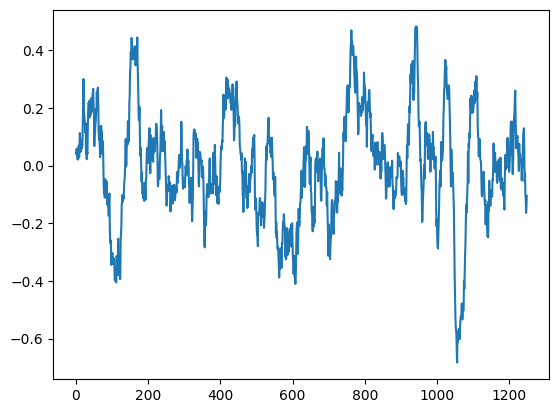

In [27]:
x, y = next(iter(dataloader))
out = torch.sigmoid(model(x))
plt.plot(x[0, 0, :])
print(f"Real: {y[0]}, Predicted: {out[0]}")

Running the fake nap through our model and making sure the activations look good:

In [ ]:
from tqdm import tqdm
buffer = DataBuffer(len_spindle)
outputs = {}
for i in tqdm(range(len_sequence)):
    window = buffer.step(noisy_data[:, i])
    if i % (Fs // 4) == 0:
        output = torch.sigmoid(model(window))
        outputs[i] = output

positives = []
for index in outputs.keys():
    for channel in range(num_channels):
        if outputs[index][channel] > 0.5 and index > len_spindle:
            positives.append((channel, index))

Found a spindle at index 4650 in channel 2


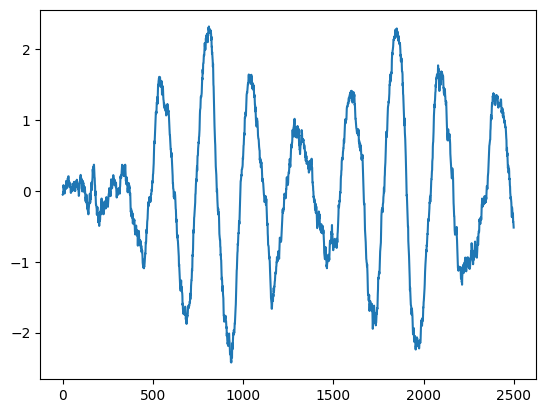

In [74]:
channel_num, index = positives[16]
print(f"Found a spindle at index {index} in channel {channel_num}")
plt.plot(noisy_data[channel_num, index-len_spindle:index+len_spindle])
plt.show()

#### Convert model to tflite to deploy on Portiloop

In [12]:
model_test = DemoModel(250, 1e-4)
model_test.load_state_dict(torch.load('/project/portiloop-training/portiloop_software/models/epoch=9-step=320.ckpt')['state_dict'])

<All keys matched successfully>

In [13]:
from torchsummary import summary
summary(model_test, (1, 1250))

We redefine the model in Keras:

In [215]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

class TinySleepNet(Model):
    def __init__(self, fs):
        super(TinySleepNet, self).__init__()
        self.feature = tf.keras.Sequential([
            layers.Conv1D(128, kernel_size=32, strides=16, input_shape=(1250, 1)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPool1D(pool_size=8, strides=8),
            layers.Dropout(0.5)
        ])
        
        self.classifier = layers.Dense(1)

    def call(self, x):
        x = self.feature(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.classifier(x)
        return x

We make sure that the model is of the exact same structure and has the right amount of weights:

In [216]:
keras_model = TinySleepNet(250)

# Create a dummy input tensor
input_tensor = np.zeros((1, 1250, 1), dtype=np.float32)

# Perform a forward pass on the Keras model to initialize the weights
keras_model.predict(input_tensor)

keras_model.summary()

1/1 [==============================] - 0s 114ms/step
Model: "tiny_sleep_net_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 9, 128)            4736      
                                                                 
 dense_25 (Dense)            multiple                  1153      
                                                                 
Total params: 5,889
Trainable params: 5,633
Non-trainable params: 256
_________________________________________________________________


This makes sure that our model is in evaluation mode and allows us to actually copy the weights:

In [217]:
model_test.parameters
model_test.train(False)

DemoModel(
  (model): TinySleepNet(
    (feature): Sequential(
      (0): Conv1d(1, 128, kernel_size=(32,), stride=(16,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
    )
    (classifier): Linear(in_features=1152, out_features=1, bias=True)
  )
  (criterion): BCEWithLogitsLoss()
)

This is the part where a bit of trial and error is necessary to make sure you have the right weight structure. Here is where we actually copy the weights from one layer to another.

In [218]:
for keras_layer in keras_model.layers:
    if isinstance(keras_layer, tf.keras.Sequential):
        for layer in keras_layer.layers:
            if isinstance(layer, tf.keras.layers.Conv1D):
                layer.set_weights([model_test.model.feature[0].weight.detach().cpu().numpy().T, model_test.model.feature[0].bias.detach().cpu().numpy()])
            elif isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.set_weights([
                    model_test.model.feature[1].weight.detach().cpu().numpy(), 
                    model_test.model.feature[1].bias.detach().cpu().numpy(),
                    model_test.model.feature[1].running_mean.detach().cpu().numpy(), 
                    model_test.model.feature[1].running_var.detach().cpu().numpy()])
            else: 
                print("Layer skipped " + str(layer))
    elif isinstance(keras_layer, tf.keras.layers.Dense):
        keras_layer.set_weights([model_test.model.classifier.weight.detach().cpu().numpy().T, model_test.model.classifier.bias.detach().cpu().numpy()])
    else:
        print("Layer skipped " + str(keras_layer))

Layer skipped <keras.layers.activation.relu.ReLU object at 0x7f9044525c00>
Layer skipped <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7f904454abf0>
Layer skipped <keras.layers.regularization.dropout.Dropout object at 0x7f9044548b20>


In [228]:
tst_input = torch.ones((1, 1, 1250)).cuda()
model_test.train(False)
model_test(tst_input)

tensor([[0.9609]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [229]:
keras_model(tst_input.cpu().numpy().reshape(1, 1250, 1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0104902]], dtype=float32)>

In [230]:
saved_model_dir = '/project/portiloop-training/portiloop_software/models/demo_model_keras'
keras_model.save(saved_model_dir)

2023-06-26 21:57:02.153856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,9,128]
	 [[{{node inputs}}]]
2023-06-26 21:57:02.617883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,9,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /project/portiloop-training/portiloop_software/models/demo_model_keras/assets


INFO:tensorflow:Assets written to: /project/portiloop-training/portiloop_software/models/demo_model_keras/assets


#### Quantizing the model

In [231]:
def representative_dataset():
    for i in range(1000):
        yield [dataset[i][0].reshape(1, 1250, 1).numpy().astype(np.float32)]

In [244]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

2023-06-26 22:00:42.804720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-26 22:00:42.804771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-26 22:00:42.805906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /project/portiloop-training/portiloop_software/models/demo_model_keras
2023-06-26 22:00:42.808431: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-26 22:00:42.808453: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /project/portiloop-training/portiloop_software/models/demo_model_keras
2023-06-26 22:00:42.814413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-26 22:00:42.815599: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-26 22:00:42.843119: I tensorflow/cc

In [245]:
with open('/project/portiloop-training/portiloop_software/models/demo_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [251]:
interpreter = tf.lite.Interpreter('/project/portiloop-training/portiloop_software/models/demo_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def forward_tflite(input):

    # convert input to int 
    input_scale, input_zero_point = input_details[0]["quantization"]
    input = np.asarray(input) / input_scale + input_zero_point
    input_data_x = input.astype(input_details[0]["dtype"])

    # Test the model on random input data.
    input_shape_x = input_details[0]['shape']

    interpreter.set_tensor(input_details[0]['index'], input_data_x)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data_y = interpreter.get_tensor(output_details[0]['index'])

    output_scale, output_zero_point = output_details[0]["quantization"]
    output_data_y = float(output_data_y - output_zero_point) * output_scale

    return output_data_y

In [254]:
input = np.ones((1, 1250, 1), dtype=np.float32)
forward_tflite(input)